In [1]:
import torch
import h5py
import numpy as np
import pretty_midi
import cv2
import os

from torch.utils.data import Dataset
from bisect import bisect_right
from tqdm import tqdm

In [2]:
class R3FullDataset(Dataset):
  def __init__(self, hdf5_path, train_folder, fps=30, sequence_length=5):
    self.hdf5_path = hdf5_path
    self.train_folder = train_folder
    self.seq_len = sequence_length
    self.fps = fps
    self.segments = []
    self.total_frames = 0
    
    print(f"Scanning HDF5 groups in {os.path.basename(hdf5_path)}")
    
    with h5py.File(self.hdf5_path, 'r') as f:
        group_names = list(f.keys())
        group_names.sort()
          
        print(f"Processing MIDI labels for {len(group_names)} splits")
        for name in tqdm(group_names):
            # 1. Check if corresponding MIDI exists
            midi_filename = name + ".midi"
            midi_path = os.path.join(self.train_folder, midi_filename)
            
            if not os.path.exists(midi_path):
                continue

            n_frames = f[name]['frames'].shape[0]
            midi_data = pretty_midi.PrettyMIDI(midi_path)
            split_labels = np.zeros((n_frames, 88), dtype=np.float32)
                
            for note in midi_data.instruments[0].notes:
              start_f = int(note.start * self.fps)
              end_f = int(note.end * self.fps)
              
              # Clamp to valid range
              start_f = max(0, start_f)
              end_f = min(n_frames, end_f)
              
              if start_f < end_f:
                  key_idx = note.pitch - 21
                  if 0 <= key_idx < 88:
                      split_labels[start_f:end_f, key_idx] = 1.0

            valid_frames = n_frames - self.seq_len
            
            if valid_frames > 0:
                start_idx = self.total_frames
                end_idx = start_idx + valid_frames
                
                self.segments.append({
                    'start': start_idx,
                    'end': end_idx,
                    'name': name,
                    'labels': split_labels
                })
                  
                self.total_frames += valid_frames
    
    # Create a lookup table for fast indexing
    self.cumulative_indices = [s['end'] for s in self.segments]
    print(f"Loaded {len(self.segments)} splits. Total Samples: {self.total_frames}")

  def __len__(self):
    return self.total_frames

  def __getitem__(self, idx):
      segment_idx = bisect_right(self.cumulative_indices, idx)
      segment = self.segments[segment_idx]
      local_idx = idx - segment['start']
      
      # 3. Retrieve Data
      with h5py.File(self.hdf5_path, 'r') as f:
        group = f[segment['name']]
        binary_frames = group['frames'][local_idx : local_idx + self.seq_len]
        
      # Decode Images
      decoded_frames = []
      for bin_data in binary_frames:
          file_bytes = np.frombuffer(bin_data, dtype=np.uint8)
          img = cv2.imdecode(file_bytes, cv2.IMREAD_GRAYSCALE)
          
          # Resize to match Model (224x640)
          img = cv2.resize(img, (640, 224)) 
          
          img = img.astype(np.float32) / 255.0
          decoded_frames.append(img)
          
      video_tensor = torch.from_numpy(np.array(decoded_frames)).unsqueeze(0)
      label_vec = segment['labels'][local_idx + self.seq_len - 1]
      label_tensor = torch.from_numpy(label_vec)
      
      return video_tensor, label_tensor

In [3]:
# Define paths
h5_file = 'processed_r3s/train/r3s_processed.hdf5'
train_folder = 'processed_r3s/train/' # Folder containing all the .midi files

# Initialize (This will take a minute to process all MIDI files)
full_dataset = R3FullDataset(h5_file, train_folder, fps=30)

Scanning HDF5 groups in r3s_processed.hdf5
Processing MIDI labels for 219 splits


100%|██████████| 219/219 [00:05<00:00, 37.90it/s]

Loaded 219 splits. Total Samples: 920699


In [4]:
print(f"Total Training Samples: {len(full_dataset)}")
print(f"Number of Splits Loaded: {len(full_dataset.segments)}")

idx = len(full_dataset) // 2
vid, label = full_dataset[idx]

print(f"Sample {idx} shape: {vid.shape}")
print(f"Active keys: {torch.where(label==1)[0].tolist()}")

Total Training Samples: 920699
Number of Splits Loaded: 219
Sample 460349 shape: torch.Size([1, 5, 224, 640])
Active keys: [34, 46, 49, 54, 58]


In [5]:
# Path to your data
h5_path = 'processed_r3s/train/r3s_processed.hdf5'
split_name = 'rach3_2020-10-09_a01_full_split10' # The one matching your text file

with h5py.File(h5_path, 'r') as f:
    if split_name in f:
        frame_count = f[split_name]['frames'].shape[0]
        duration = 191.65
        fps = frame_count / duration
        
        print(f"🎬 Frames: {frame_count}")
        print(f"⏱️ Duration: {duration}s")
        print(f"🎯 Calculated FPS: {fps:.4f}")
    else:
        print(f"❌ Could not find group: {split_name}")

🎬 Frames: 5750
⏱️ Duration: 191.65s
🎯 Calculated FPS: 30.0026


# EDA

In [6]:
import matplotlib.pyplot as plt

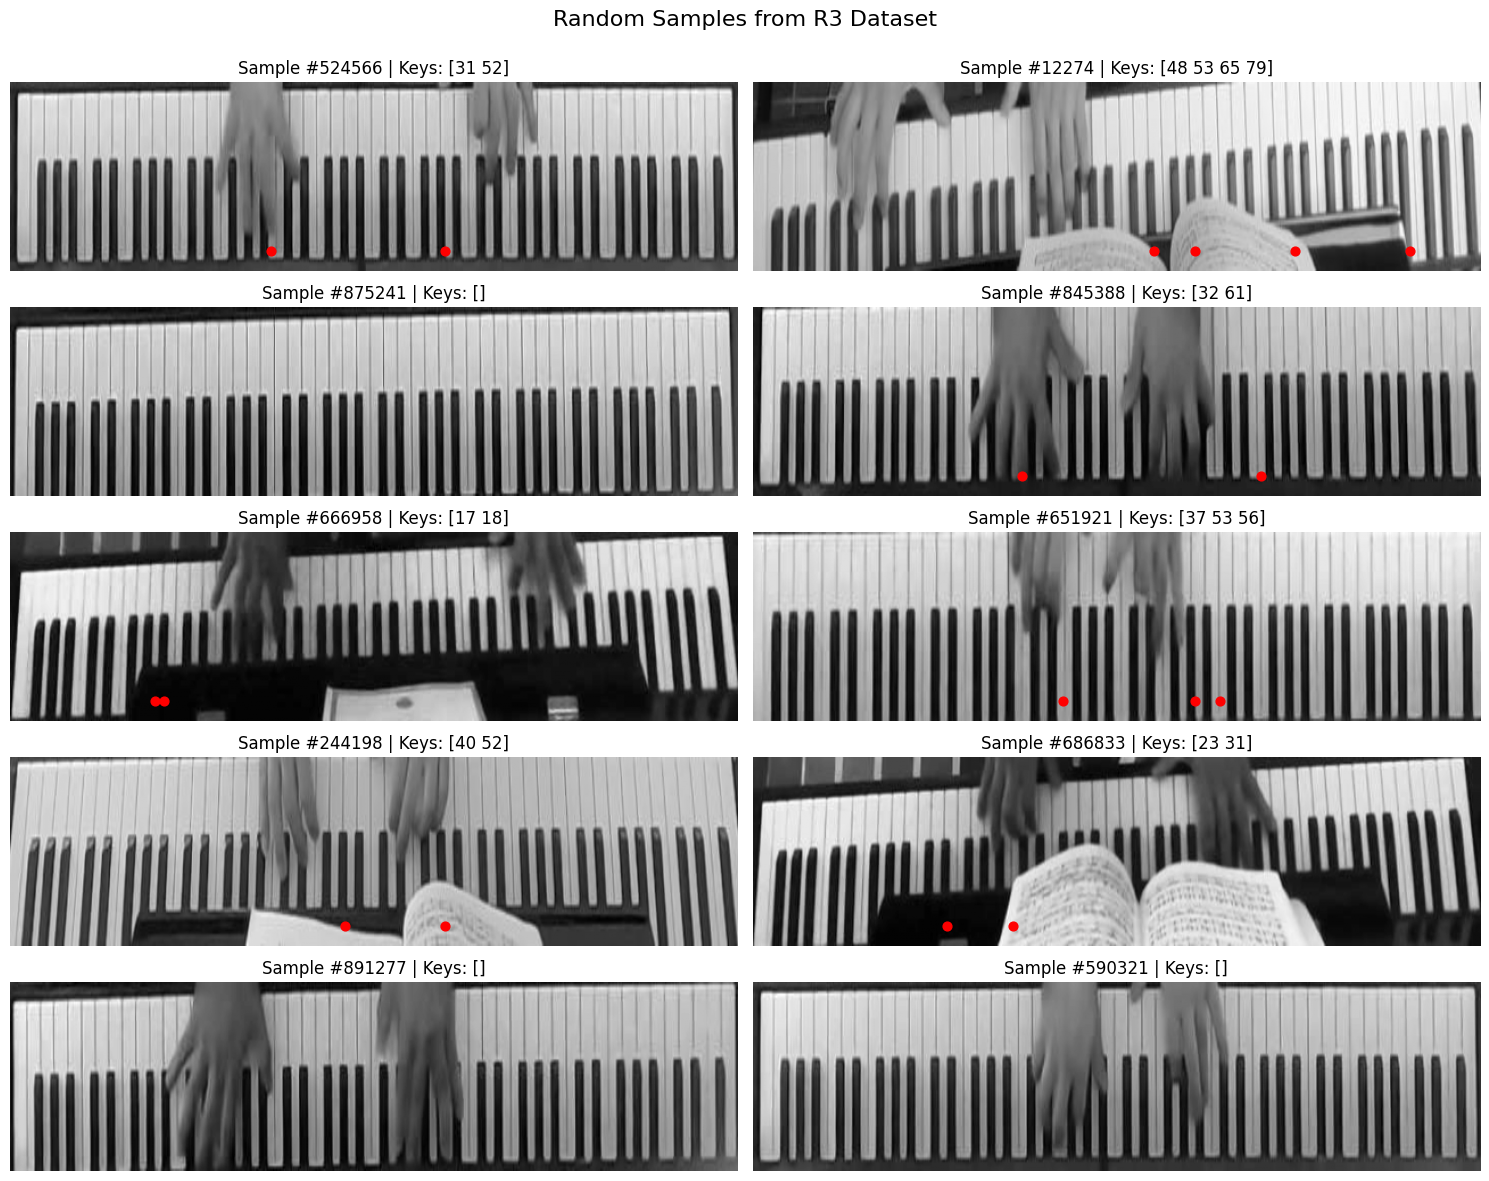

In [7]:
fig, axes = plt.subplots(5, 2, figsize=(15, 12))
fig.suptitle("Random Samples from R3 Dataset", fontsize=16)
axes = axes.flatten()

for i in range(10):
    # Pick a random index
    idx = np.random.randint(0, len(full_dataset))
    
    # Get data
    video_tensor, label_tensor = full_dataset[idx]
    image = video_tensor[0, -1, :, :].numpy()
    active_keys = torch.where(label_tensor == 1)[0].numpy()
    
    # Plot image
    axes[i].imshow(image, cmap='gray', aspect='auto')
    
    # Draw red dots for active keys
    key_width = 640 / 88
    if len(active_keys) > 0:
        x_pos = (active_keys * key_width) + (key_width / 2)
        axes[i].scatter(x_pos, [200]*len(x_pos), c='red', s=40, marker='o')
    
    axes[i].set_title(f"Sample #{idx} | Keys: {active_keys}")
    axes[i].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

allignment check

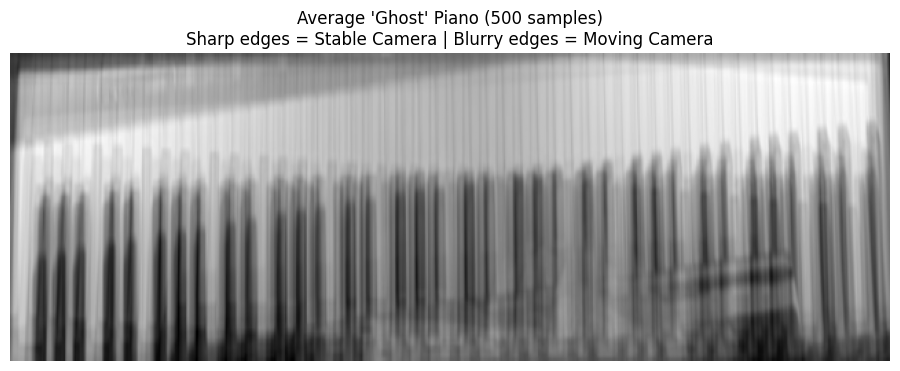

In [8]:
N_SAMPLE = 500
accumulated_img = np.zeros((224, 640), dtype=np.float32)

for i in range(N_SAMPLE):
  idx = np.random.randint(0, len(full_dataset))

  tensor, _ = full_dataset[idx]
  frame = tensor[0, -1, :, :].numpy()
  
  accumulated_img += frame

mean_image = accumulated_img / N_SAMPLE

plt.figure(figsize=(12, 4))
plt.imshow(mean_image, cmap='gray')
plt.title(f"Average 'Ghost' Piano ({N_SAMPLE} samples)\nSharp edges = Stable Camera | Blurry edges = Moving Camera")
plt.axis('off')
plt.show()

# Preprocessing

In [9]:
def apply_augmentations(video_tensor):
  if video_tensor.size(0) == 0:
    return video_tensor
  
  if torch.rand(1).item() < 0.8:
    # Create a brightness factor (e.g., 0.7x to 1.3x)
    brightness = (torch.rand(1).item() * 0.6) + 0.7
    video_tensor = video_tensor * brightness
  
  if torch.rand(1).item() < 0.5:
    # Noise strength
    noise_level = 0.03 
    noise = torch.randn_like(video_tensor) * noise_level
    video_tensor = video_tensor + noise
  
  return torch.clamp(video_tensor, 0.0, 1.0)

In [10]:
import torch.nn as nn
import torchvision.models as models

class VisualPianoModel(nn.Module):
  def __init__(self, num_keys=88, input_height=224, input_width=640):
    super().__init__()
    
    # --- PATH 1: Motion Detector (3D Conv) ---
    # Looks at the sequence of 5 frames to detect movement
    self.motion_conv = nn.Sequential(
      nn.Conv3d(1, 64, kernel_size=(5, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False),
      nn.BatchNorm3d(64),
      nn.ReLU(inplace=True)
    )
    
    # --- PATH 2: Static Detector (2D Conv) ---
    # Looks ONLY at the last frame to detect held keys
    self.static_conv = nn.Sequential(
      nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
      nn.BatchNorm2d(64),
      nn.ReLU(inplace=True)
    )
    
    # --- Backbone: ResNet18 ---
    # We perform surgery on ResNet18 to let it accept our custom inputs
    resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    self.features = nn.Sequential(
      resnet.maxpool,
      resnet.layer1,
      resnet.layer2,
      resnet.layer3,
      resnet.layer4
    )
    
    # Vertical Compression (Squash the height, keep the width)
    self.vertical_pool = nn.AdaptiveAvgPool2d((1, None)) 
    
    # Auto-Calculate Linear Layer Size (The "Self-Configuring" trick)
    with torch.no_grad():
      dummy_3d = torch.zeros(1, 1, 5, input_height, input_width)
      dummy_2d = torch.zeros(1, 1, input_height, input_width)
      
      m = self.motion_conv(dummy_3d).squeeze(2)
      s = self.static_conv(dummy_2d)
      combined = m + s
      feat = self.features(combined)
      feat = self.vertical_pool(feat)
      self.flat_size = feat.numel()
    
    # Final Classifier
    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(self.flat_size, num_keys)
    )

  def forward(self, x):
    # x shape: [Batch, 1, 5, H, W]
    
    # 1. Process Motion (Time)
    motion = self.motion_conv(x)
    motion = motion.squeeze(2) # Remove time dimension
    
    # 2. Process Static (Last Frame)
    last_frame = x[:, :, -1, :, :] 
    static = self.static_conv(last_frame)
    
    # 3. Combine them (The "Secret Sauce" from the article)
    x = motion + static
    
    # 4. Extract Features & Classify
    x = self.features(x)
    x = self.vertical_pool(x)
    x = self.classifier(x)
    return x

# Training

In [11]:
BATCH_SIZE = 16        # Lower this if you get "CUDA Out of Memory"
LEARNING_RATE = 1e-4   
EPOCHS = 1             # Start with 1 to test
SAVE_DIR = "checkpoints"
os.makedirs(SAVE_DIR, exist_ok=True)

In [12]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE}")

Training on cuda


In [13]:
import torch.optim as optim

model = VisualPianoModel(num_keys=88, input_height=224, input_width=640)
model = model.to(DEVICE)

pos_weight = torch.ones([88]).to(DEVICE) * 15
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\njovi/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:26<00:00, 1.77MB/s]


In [ ]:
from torch.utils.data import DataLoader

# Ganti num_workers jadi 2 atau 4 (jangan kegedean nanti RAM meledak)
train_loader = DataLoader(full_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
steps_per_epoch = len(train_loader)

print(f"Starting Loop: {steps_per_epoch} batches per epoch")
for epoch in range(EPOCHS):
  model.train()
  running_loss = 0.0
  progress_bar = tqdm(enumerate(train_loader), total=steps_per_epoch, desc=f"Epoch {epoch+1}")
  
  for step, (inputs, labels) in progress_bar:
    inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
    
    # --- 🧼 THE CLEAN PREPROCESSING CALL ---
    # We modify the inputs right here before the model sees them
    inputs = apply_augmentations(inputs)
    # ---------------------------------------
    
    optimizer.zero_grad()
    
    # Forward & Backward
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    
    # Metrics
    running_loss += loss.item()
    avg_loss = running_loss / (step + 1)
    progress_bar.set_postfix({'loss': f'{avg_loss:.4f}'})
    
    # Checkpoint every 2000 steps
    if step > 0 and step % 2000 == 0:
        torch.save(model.state_dict(), f"{SAVE_DIR}/model_epoch{epoch+1}_step{step}.pth")

  # Save Final
  torch.save(model.state_dict(), f"{SAVE_DIR}/final_model_epoch{epoch+1}.pth")
  print(f"✅ Epoch {epoch+1} Finished.")

Starting Loop: 57544 batches per epoch


Epoch 1:   3%|▎         | 1817/57544 [06:45<3:09:49,  4.89it/s, loss=0.3174]